<a href="https://colab.research.google.com/github/Surojit-KB/UNIV-AI-ML2-Lab3/blob/main/Copy_of_Lab3_Scaffold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3:  Bayesian Tomatoes
### Univ.AI 
### ML-2 Cohort-1

<div class="banner-container">
<img src="http://content7.flixster.com/movie/11/16/81/11168101_det.jpg" width=180>

<img src="http://content6.flixster.com/movie/11/15/15/11151508_det.jpg" width=180>

<img src="http://content9.flixster.com/movie/11/16/61/11166199_det.jpg" width=180>
</div>

In this lab, you'll be analyzing movie reviews from [Rotten Tomatoes](http://www.rottentomatoes.com). This lab will cover:

 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

Rotten Tomatoes gathers movie reviews from critics. An [entry on the website](http://www.rottentomatoes.com/m/primer/reviews/?type=top_critics) typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.


When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

 * Is a movie review positive or negative?
 * Is an email spam, or not?
 
Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques.  

In [ ]:
#Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import brier_score_loss

## Load and explore the data

In [ ]:
critics = pd.read_csv('https://raw.githubusercontent.com/Surojit-KB/Lab3-1/main/data/critics.csv?token=AQT2I742XPFC3FXWRI7Z7KLAL5CQO')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
critics.to_csv('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML2/LABS/critics.csv')

In [ ]:
critics = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML2/LABS/critics.csv',index)
#Remove all the rows with no reviews 
critics = critics[~critics.quote.isnull()]
#Take a look at the dataset
critics.head()

,Unnamed: 0,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [ ]:
critics.columns

Index(['Unnamed: 0', 'critic', 'fresh', 'imdb', 'publication', 'quote',
       'review_date', 'rtid', 'title'],
      dtype='object')

In [ ]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print ("Number of reviews: ",  n_reviews)
print ("Number of critics: " ,n_critics)
print ("Number of movies: " , n_movies)

Number of reviews:  15561
Number of critics:  623
Number of movies:  1921


## Naive Bayes Sentiment Analysis

You will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. 

We need to convert the textual collection of reviews to something numerical. A common strategy for text classification is to represent each review as a "bag of words" vector -- a long vector
of numbers encoding how many times a particular word appears in a review.

Scikit-learn has an object called a `CountVectorizer` that turns text into a bag of words. 

### BOW
Using the `critics` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.

In [ ]:
def make_xy(critics, vectorizer=None):   
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [ ]:
X, Y = make_xy(critics)

### Multionomial Naive Bayes Model


Next, randomly split the data into two groups: a
training set and a validation set. 

Use the training set to train a `MultinomialNB` classifier,
and print the accuracy of this model on the validation set

In [ ]:
#Split the train and test set and fit a MultinomialNB model
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8)
clf=MultinomialNB()
#your code here
clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
#Compute the train and test accuracy 
print('Train score:',model.score(X_train,y_train))
print('Test score:',model.score(X_test,y_test))
#your code here

Train score: 0.9194248071979434
Test score: 0.7751365242531321


### Model Calibration

Being the respectable Bayesian that you are, you should always assess whether these probabilities are **calibrated** -- that is, whether a prediction made with a confidence of `x%` is correct approximately `x%` of the time.

Let's make a plot to assess model calibration. Remember from the lecture, we want something like this:

<img src="http://i.imgur.com/ea5B6zr.png" width=500px>

In words, we want to:

* Take a collection of examples, and compute the freshness probability for each using `clf.predict_proba`
* Gather examples into bins of similar freshness probability (the diagram shows 5 groups -- you should use something closer to 20)
* For each bin, count the number of examples in that bin, and compute the fraction of examples in the bin which are fresh
* **Optional:** In the upper plot, graph the expected P(Fresh) (x axis) and observed freshness fraction (Y axis). Estimate the uncertainty in observed freshness fraction $F$ via the [equation](http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) $\sigma = \sqrt{F (1-F) / N}$
* Overplot the line y=x. This is the trend we would expect if the model is calibrated
* In the lower plot, show the number of examples in each bin


In [ ]:
clf.predict_proba(X_test)[:,1]

array([0.99322239, 0.523703  , 0.73760829, ..., 0.4851889 , 0.0360717 ,
       0.99902841])

In [ ]:
def calibration_plot(clf, xtest, ytest):
    #your code here
    prob_pos = clf.predict_proba(xtest)[:,1]
    fraction_of_positives, mean_predicted_value = calibration_curve(ytest, prob_pos, n_bins=20)
    clf_score = brier_score_loss(ytest, prob_pos, pos_label=ytest.max())
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="(%1.3f)" % (clf_score))
    ax1.plot([0,1], [0,1], "k--")
    ax2.hist(prob_pos, range=(0, 1), bins=20, label="logistic",
         histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

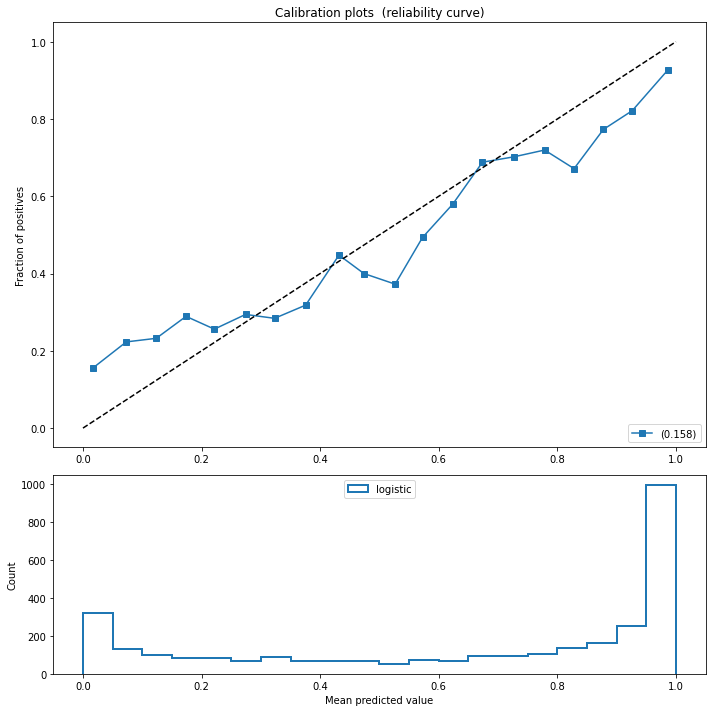

In [ ]:
calibration_plot(clf, X_test ,y_test)

#### Cross Validation

Our classifier has a few free parameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 


Using `clf.predict_logproba`, write a function that computes the log-likelihood of a dataset

In [ ]:
y_log_pred=clf.predict_log_proba(X_test)[:,1]

In [ ]:
ind_1=(y_test==1)

In [ ]:
y_log_pred[ind_1]

array([-0.00680068, -0.64683055, -0.30434237, ..., -0.00232591,
       -0.00092449, -0.00097206])

In [ ]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
clf : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
def log_likelihood(clf, x, y):
    y_log_pred=clf.predict_log_proba(x)[:,1]
    L=np.sum(y_log_pred[y==1])+np.sum(y_log_pred[y==0])
    return L
    #your code here

In [ ]:
def cv_score(clf, x, y, score_func):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by randomly splitting (x, y) into training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    
    #your code here
    score=np.mean(cross_val_score(clf,x,y,cv=5,n_jobs=-1,scoring=score_func))
    return score

Find which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

In [ ]:
def make_xy(critics,min_df, vectorizer=None):   
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df=min_df)
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  
    Y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, Y

In [ ]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf


#your code here
for alpha in alphas:
  for df in min_dfs:
    X,Y=make_xy(critics,df)
    clf=MultinomialNB(alpha=alpha)
    score=cv_score(clf,X,Y,log_likelihood())
    if score>max_loglike:
      max_loglike=score
      best_alpha=alpha
      best_min_df=df

TypeError: ignored

In [ ]:
print( "alpha: " , best_alpha)
print ("min_df:",best_min_df)

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, train a final classifier with these parameters, re-evaluate the accuracy, and draw a new calibration plot.

In [ ]:
#your code here

Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse? Is the model more or less calibrated?

**Answer** *The new model is slightly less accurate on the test data (74% vs 77% on the original model). However, it is both better calibrated and less over-fit than before. In other words, while the classification accuracy is slightly worse, the probabilities themselves are more accurate. The model is still slightly over-confident when making low P(Fresh) predictions. However, the calibration plot shows the model is usually within 1 error bar of the expected performance where P(Fresh) >= 0.2. Finally, the new model makes less-conclusive predictions on average -- the histogram in the calibration plot is more uniformly distributed, with fewer predictions clustered around P(Fresh) = 0 or 1.*

## Interpretation. What words best predict a fresh or rotten review?

Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words
that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints

* Try computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?


In [ ]:
## Your code here

words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = ________
ind = ________

good_words = ________
bad_words = ________

good_prob = ________
bad_prob = ________

print ("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print ("%20s" % w, "%0.2f" % (1 - np.exp(p)))
    
print ("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print ("%20s" % w, "%0.2f" % (1 - np.exp(p)))

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly. 

Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

In [ ]:
x, y = make_xy(critics, vectorizer)

prob = _____
predict = clf.predict(x)

#your code here


Mis-predicted Rotten quotes
---------------------------
Like most remakes, The Fog is pretty unnecessary.
If watched from a mildly amused, forgiving distance, the movie has its enjoyable moments -- good and campy.
It is a work of art created by grown people for grown people.
Personal as the story he is telling may be, what separates this film from Allen's own past work and most other recent comedy is its general believability.
Are you bored yet?
---------------------------
---------------------------
Mis-predicted Fresh quotes
--------------------------
That implacable moral balance, in which good eventually silences evil, is at the heart of the Western, and Eastwood is not shy about saying so.
The director's real achievement is not in making a piece of agitprop but in using these fundamental tools of cinema in such an extraordinarily affecting way.
Although Giant may not be a classic in the purest sense of the word, it's a fine example of a virtually-extinct genre.
A good ride, briskl

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

Try your own sentences!

In [ ]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))